In [31]:
%reset -f
import math
import matplotlib.pyplot as plt
import numpy as np

def AMAX1(left, right):
    return max(left, right)

# BODEK PARAMETRIZATION
# Describes resonanses
def bodek(WM,QSQ, bodek_0, bodek_1, bodek_2, bodek_3, bodek_4, bodek_5, bodek_6, bodek_7, bodek_8, bodek_9, bodek_10):

    if (WM < 0.94): 
        return 0.
    
    PMSQ = 0.880324
    PM2 = 1.876512
    PM = 0.938256
    NRES = 4
    NBKG = 5  
    LSPIN = [0.,1,2,3,2]
    # first element just to shift index by 1 (pythom -> fortran) there is no other meaning in C[0] and L[0]
    LSPIN = [0.,1,2,3,2]

    #after elas:
    # it can be PRC parameters or not, 
    # it does not matter bacause the code will always overwrite them
    # Consider them as a placeholder
    # If you decide to use them, check what it is

    # constants - do not change. 
    C = [0.,1.0741163,0.75531124,3.3506491,1.7447015,3.5102405,1.14391,
         1.2299128,0.114735,0.621974,1.49826,0.12269,0.514898,
         1.71184,0.1177,0.51329,1.94343,0.202702,-0.17498537,
         0.0096701919,-0.035256748,3.5185207,-0.599937,4.7615828,0.41167589]

    # mass not used
    if (False):
        #C[7]=bodek_0
        #remove peak shift
        C[10]=bodek_0
        C[13]=bodek_1
            
    C[16]=bodek_2
    #amplitude
        
    C[6]=bodek_3
    C[9]=bodek_4
    C[12]=bodek_5
    C[15]=bodek_6
    
    #width
    C[8]=bodek_7
    C[11]=bodek_8
    C[14]=bodek_9
    C[17]=bodek_10
    
    WSQ=WM*WM
    OMEGA=1.+(WSQ-PMSQ)/QSQ                                           
    X=1./OMEGA                                                        
    XPX=C[22]+C[23]*(X-C[24])**2                                      
    PIEMSQ=(C[1]-PM)**2                                               

    # added part (Misak's comment)
    B1 = 0.0
    B2 = 0.0
    # 0/0
    if (WM != C[1]):
        B1=AMAX1(0.,(WM-C[1]))/(WM-C[1])*C[2]
    EB1=C[3]*(WM-C[1])
    if (EB1 <= 25.):
        B1=B1*(1.0-math.exp(-EB1))
        
    if (WM != C[4]):
        #AMAX1
        B2=AMAX1(0.,(WM-C[4]))/(WM-C[4])*(1.-C[2])

    EB2=C[5]*(WSQ-C[4]**2)                                           
    if (EB2 <= 25.):
        B2=B2*(1.-math.exp(-EB2))
    BBKG=B1+B2
    BRES=C[2]+B2                                                      
    RESSUM=0.

    for I in range(1,5,1):
        INDEX=(I-1)*3+1+NBKG
        #amplitude
        RAM=C[INDEX]
        #print(INDEX, C[INDEX])
        if (I == 1):
            RAM=C[INDEX]+C[18]*QSQ+C[19]*QSQ**2 
        #IF(I.EQ.1)RAM=C(INDEX)+C(18)*QSQ+C(19)*QSQ**2
        # mass
        #print(INDEX+1, C[INDEX+1])
        RMA=C[INDEX+1]
        if (I == 3):
            RMA=RMA*(1.+C[20]/(1.+C[21]*QSQ))
        #IF(I.EQ.3)RMA=RMA*(1.+C(20)/(1.+C(21)*QSQ))                       A1506350
        
        RWD=C[INDEX+2]
        QSTARN=math.sqrt(AMAX1(0.,((WSQ+PMSQ-PIEMSQ)/(2.*WM))**2-PMSQ))
        QSTARO=math.sqrt(AMAX1(0.,((RMA**2-PMSQ+PIEMSQ)/(2.*RMA))**2-PIEMSQ))
        RES = 0
        #IF(QSTARO.LE.1.E-10)GO TO 40                                      A1506390
        if (QSTARO < 1e-10):
            RES = 0
        else:
            TERM=6.08974*QSTARN
            TERMO=6.08974*QSTARO
            J=2*LSPIN[I]
            K=J+1
            GAMRES=RWD*(TERM/TERMO)**K*(1.+TERMO**J)/(1.+TERM**J)
            GAMRES=GAMRES/2.
            BRWIG=GAMRES/((WM-RMA)**2+GAMRES**2)/3.1415926
            RES=RAM*BRWIG/PM2
            RESSUM=RESSUM+RES                                                 
    B=BBKG*(1.+(1.-BBKG)*XPX)+RESSUM*(1.-BRES)
    return B



def fact(g2,x):
    result=1.135
    if (x > 0.1 and x < 0.2 and g2 < 0.5):
        return result
    if (x > 0.1 and g2 < 0.5):
        return result
    return 1.


# background function,
def gp_h(q0,q2, backg_0, backg_1, backg_2, backg_3, backg_4):
    pm=0.938279
    pi=3.14159
    xx = q2/(2.*pm*q0)
    gi = 2.*pm*q0
    ww = (gi+1.642)/(q2+0.376)
    t  = (1.-1./ww)
  
    wp = 0.24035*t**3+backg_1*t**4+backg_2*t**5+backg_3*t**6+backg_4*t**7
    result=wp*ww*q2/(2.*pm*q0)*fact(q2,xx)
    
    return result

def w2h(gp2,gp0, backg_0, backg_1, backg_2, backg_3, backg_4, 
        bodek_0, bodek_1, bodek_2, bodek_3, bodek_4, bodek_5, bodek_6, bodek_7, bodek_8, bodek_9, bodek_10):
    
    pm=0.938279
    pi=3.14159
    fm2=pm**2+2.*pm*gp0-gp2
    w2h=0.
    if (fm2 < pm**2):
        return 0
    wi=math.sqrt(fm2)
    # gp_h and b
    result=gp_h(gp0, gp2, backg_0, backg_1, backg_2, backg_3, backg_4) * bodek(wi, gp2, bodek_0, bodek_1, bodek_2, bodek_3, bodek_4, bodek_5, bodek_6, bodek_7, bodek_8, bodek_9, bodek_10) / gp0
    return  result

# Mott cross section
def gmott(ei,ue):
    g1=(1./137)**2*math.cos(ue/2.)**2
    g2=4.*ei**2*math.sin(ue/2.)**4
    result=g1/g2*0.389385*1000.*1000.
    return result

# Inelastic scattering on hydrogen
def h_inel(ei,er,ue,
           # background
           backg_0, backg_1, backg_2, backg_3, backg_4,
           # bodek params
           bodek_0, bodek_1, bodek_2, bodek_3, bodek_4, bodek_5, bodek_6, 
           bodek_7, bodek_8, bodek_9, bodek_10
          ):
    
    pm=0.938279
    pi=3.14159
    r   = 0.18
    gp0 = ei-er
    gp2 = 4.*ei*er*math.sin(ue/2.)**2
    gpv = math.sqrt(gp2+gp0**2)
    # MOTT CS
    gm  = gmott(ei,ue)
    #W2H
    w1h = (1.+gp0**2/gp2)/(1.+r)*w2h(gp2,gp0, 
                                     # background:
                                     backg_0, backg_1, backg_2, backg_3, backg_4, 
                                     # bodek:
                                     bodek_0, bodek_1, bodek_2, bodek_3, bodek_4, 
                                     bodek_5, bodek_6, bodek_7, bodek_8, 
                                     bodek_9, bodek_10)
    w2  = pm**2+2.*pm*gp0-gp2
    w = 0.
    if (w2 < 0.):
        w = 0.
    else:
        w = math.sqrt(w2)
        
    result = (gm*(w2h(gp2, gp0, backg_0, backg_1, backg_2, backg_3, backg_4,
                      bodek_0, bodek_1, bodek_2, bodek_3, bodek_4, bodek_5, 
                      bodek_6, bodek_7, bodek_8, bodek_9, bodek_10)+2.*math.tan(ue/2.)**2*w1h))

    return result

# plot background function only
def PlotBack(q2_in, w_in, backg_0, backg_1, backg_2, backg_3, backg_4):
    
    #initialize beam conditions
    ei_0   = 10.604
    ei_1   = 0./1000.
    ei     = ei_0  + ei_1
    lepin = 7
    pi=3.14159
    
    #W and Q2 to theta and P
    mass_neut = 0.939565420
    omega_lab = (w_in**2 + q2_in - mass_neut**2 ) /  (2 * mass_neut)
    er = ei_0 - omega_lab
    
    uet = 2 * math.asin(math.sqrt(q2_in / (4 * er * ei_0))) *180/pi
    
    #BLOCK OF PARAMETERS
    pm=0.938279
    em=0.000511
    alfa=1./137.
    bt=4./3.
    r=0.18

    # NANOBARN 
    v_measure = 1.
    v_m = v_measure

    #scattered angle range determination
    ue=uet*pi/180.
    

    # sub_type_spec = 11.
    
    
    ero = ei / (1.+2*ei/pm*math.sin(ue/2.)**2)
    if(ero < er):
        print('idk 1')
        return 0
    
    gp0 = ei-er
    gp2 = 4.*ei*er*math.sin(ue/2.)**2
    gpv = math.sqrt(gp0**2+gp2)
    w2  = pm**2+2.*pm*gp0-gp2
    if(w2 < 0):
        print('idk 2')
        return 0
    w   = math.sqrt(w2)
    x   = gp2/2./pm/gp0
    
    if (x > 2.0):
        print('idk 3')
        return 0
    
    q2 = 4.0*ei*er*math.sin(ue/2.0)**2
    epsilon=1./(1.+2.*(1.+(ei-er)**2/q2)*(math.tan(ue/2))**2)
    gamma_t=alfa*(w2-pm**2)*er/4./q2/pm/ei/(1-epsilon)/pi**2
    gamma_w=alfa*(w2-pm**2)*w/8./q2/pm**2/(1-epsilon)/ei**2/pi**2
    jacob=pi*w/ei/er/pm
    
    
    
    pm=0.938279
    pi=3.14159
    r   = 0.18
    gp0 = ei-er
    gp2 = 4.*ei*er*math.sin(ue/2.)**2
    gpv = math.sqrt(gp2+gp0**2)
    # MOTT CS
    gm  = gmott(ei,ue)
    #W2H

    return gp_h(gp0, gp2, backg_0, backg_1, backg_2, backg_3, backg_4);

# uet is theta in deg
# er momentum in GeV
# the function that returns cross section for w, Q2 bin. It takes bodek parametrization parameters

#pp0, pp1, pp2, pp3, pp4, pp5, pp6, pp7, pp8, pp9 ,pp10

def getXSEC_fitting(q2_in, w_in, 
                    # background
                    backg_0, backg_1, backg_2, backg_3, backg_4,
                    # bodek params
                    bodek_0, bodek_1, bodek_2, bodek_3, bodek_4, bodek_5, bodek_6, 
                    bodek_7, bodek_8, bodek_9, bodek_10
                   ):
    
    #initialize beam conditions
    ei_0   = 10.604
    ei_1   = 0./1000.
    ei     = ei_0  + ei_1
    lepin = 7
    pi=3.14159
    
    #convert W and Q2 to theta and P
    mass_neut = 0.939565420
    omega_lab = (w_in**2 + q2_in - mass_neut**2 ) /  (2 * mass_neut)
    er = ei_0 - omega_lab
    
    uet = 2 * math.asin(math.sqrt(q2_in / (4 * er * ei_0))) *180/pi
    
    #constants
    pm=0.938279
    em=0.000511
    alfa=1./137.
    bt=4./3.
    r=0.18

    # NANOBARN 
    v_measure = 1.
    v_m = v_measure

    #scattered angle range determination
    ue=uet*pi/180.
    
    # sub_type_spec = 11.
    ero = ei / (1.+2*ei/pm*math.sin(ue/2.)**2)
    if(ero < er):
        print('idk 1')
        return 0
    
    gp0 = ei-er
    gp2 = 4.*ei*er*math.sin(ue/2.)**2
    gpv = math.sqrt(gp0**2+gp2)
    w2  = pm**2+2.*pm*gp0-gp2
    if(w2 < 0):
        print('idk 2')
        return 0
    w   = math.sqrt(w2)
    x   = gp2/2./pm/gp0
    
    if (x > 2.0):
        print('idk 3')
        return 0
    
    q2 = 4.0*ei*er*math.sin(ue/2.0)**2
    epsilon=1./(1.+2.*(1.+(ei-er)**2/q2)*(math.tan(ue/2))**2)
    gamma_t=alfa*(w2-pm**2)*er/4./q2/pm/ei/(1-epsilon)/pi**2
    gamma_w=alfa*(w2-pm**2)*w/8./q2/pm**2/(1-epsilon)/ei**2/pi**2
    jacob=pi*w/ei/er/pm
    
    #Inelastic scattering
    cs_y_in = h_inel(ei,er,ue,                    
                     # background
                     backg_0, backg_1, backg_2, backg_3, backg_4,
                     # bodek params
                     bodek_0, bodek_1, bodek_2, bodek_3, bodek_4, bodek_5, bodek_6, 
                     bodek_7, bodek_8, bodek_9, bodek_10) / v_m
    
    # Jacobian (theta, P - > w, Q2) and to nb
    cs_y_in_w = round(cs_y_in*jacob/1000,10)
    return cs_y_in_w

# Wrapper for cross section function
# Just for easier use of getXSEC_fitting. The main purpose is plotting
def getCS(q2_in, w_in, isBackPass = False, isBodekPass = False, backParams = [], bodekParams = []):
    # Number of varied params:
    # it is hardcoded in other places (for example in input of getXSEC_fitting()), so do not change it
    totalParamsBodek = 11
    totalParamsBckgr = 4

    # Default params. (the one submitted to PRC)
    if (not isBackPass):
        # PRC:
        #print("PRC backgrd fun is used")
        #backParams = [0.2367, 2.178, 0.898, -6.726, 3.718]

        # Iterated by Valerii after PRC:
        backParams = [0.2367, 2.185651400350511, 0.6782367867507779, -6.735990002785817, 4.163236272156371]

        
    if (not isBodekPass):
        # PRC:
        bodekParams = [1.5,1.711,1.94343, 1.14391, 6.21974e-01,  5.14898e-01,
                       5.13290e-01 , 1.14735e-01, 1.22690e-01, 1.17700e-01, 2.02702e-01]
        

    if (len(backParams) < totalParamsBckgr):
        raise Exception("backParams is not defined, make sure that you passed backParams, if isBackPass = True ")

    if (len(bodekParams) < totalParamsBodek):
        raise Exception("backParams is not defined, make sure that you passed isBodekPass, if isBodekPass = True ")

    # Call XSEC function
    return getXSEC_fitting(q2_in, w_in, *backParams, *bodekParams)


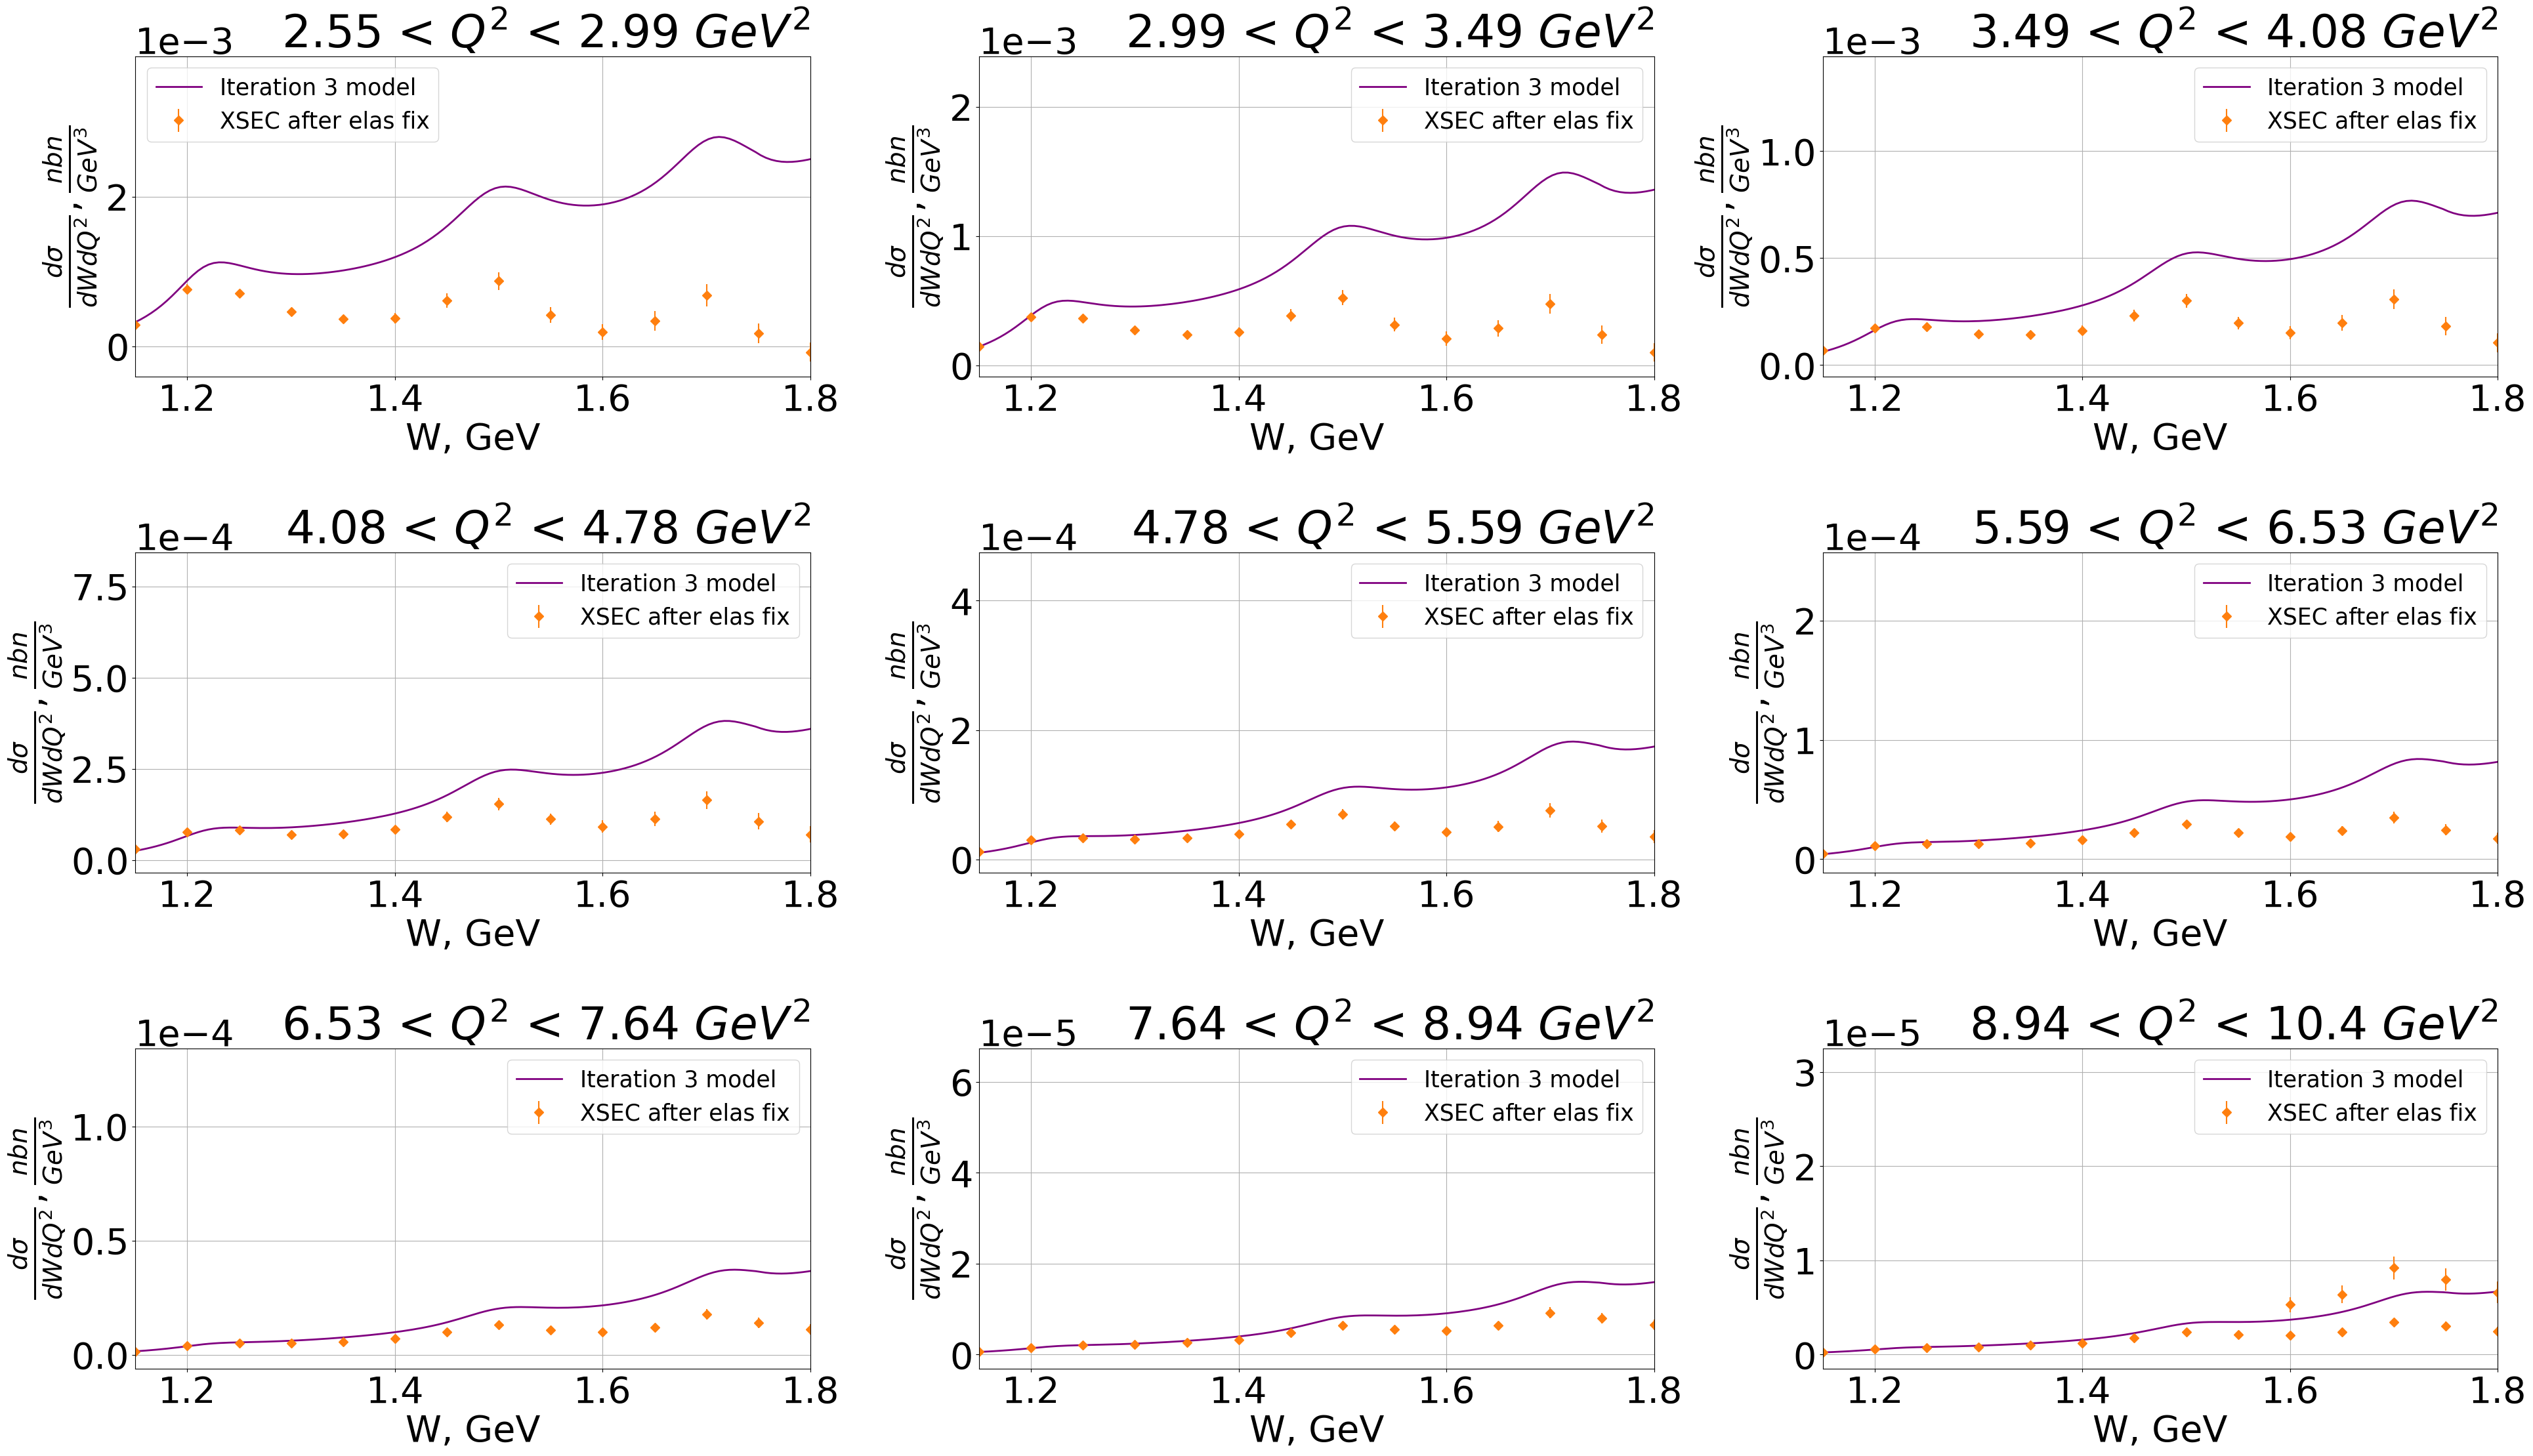

<Figure size 640x480 with 0 Axes>

In [32]:


# this cell compare model XSEC with the measured one

import math
import matplotlib.pyplot as plt
import numpy as np


Q2bins = [2.18,2.55,2.99,3.49,4.08,4.78,5.59,6.53,7.64,8.94,10.4]

xx_elas = []
yy_elas = []
yexp_elas = []
dyexp_elas = []

with open('exp_minus_pdf.txt') as ff:
    ff.readline()
    for line in ff:
        xx,yy, eps, yexp, dyexp_1, dyexp_2, dyexp_3 = [float(vv) for vv in line.strip().split(',')]
        dyexp = math.sqrt(dyexp_1**2 + dyexp_2**2 + dyexp_3**2 )
            
        xx_elas.append(xx)
        yy_elas.append(yy)
        yexp_elas.append(yexp)
        dyexp_elas.append(dyexp)

fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(45,25))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.55)



for iQ2 in range(1,10,1):
    
    x = []
    y = []
    y_0 = []
    y_iter2 = []
    y_iter3 = []
    y_iter4 = []
    q2 = xx_elas[0 + (iQ2-1) * 14]
    
    
    plotX = int((iQ2-1)/3)
    plotY = int((iQ2-1)%3)


    for xW in np.linspace(1.1, 2.6, num=300):
        x.append(xW)
        y_iter3.append(getCS(q2, xW))


    sp = 0 + (iQ2-1) * 14
    endp = 0 + (iQ2) * 14
    
    if (iQ2 == 9):
        sp-=5

    axes[plotX, plotY].errorbar(yy_elas[sp:endp], yexp_elas[sp:endp], yerr=dyexp_elas[sp:endp], linestyle="None", marker='D', markersize=7, color = '#ff7f0e', label='XSEC after elas fix')  
    
    axes[plotX, plotY].plot(x, y_iter3, label='Iteration 3 model', color = 'purple', linewidth=2)    
    
    
    title = str(Q2bins[iQ2])[0:4] + ' < $Q^2$ < ' + str(Q2bins[iQ2 +1])[0:5] + " $GeV^2$"
    axes[plotX,plotY].set_title(title, fontsize=50, loc='right') 
    axes[plotX,plotY].set_ylabel(r"$\frac{d\sigma}{dWdQ^{2}}, $"
                                 r"$\frac{nbn}{GeV^{3}}$", fontsize=40)
    axes[plotX, plotY].set_xlabel('W, GeV', fontsize=40)
    axes[plotX, plotY].grid(True)
    axes[plotX, plotY].tick_params(axis='both', which='major', labelsize=40)
    axes[plotX, plotY].ticklabel_format(style='sci', axis='y', scilimits=(-3,-6))
    axes[plotX, plotY].yaxis.get_offset_text().set_fontsize(40)
    axes[plotX, plotY].legend(fontsize=25)
    if (iQ2 < 8):
        axes[plotX, plotY].set_xlim([1.15, 1.8])
    else:
        axes[plotX, plotY].set_xlim([1.15, 1.8])
        
    
    
plt.figure()
fig.savefig('ModelTest.png', bbox_inches='tight', dpi = 50)

In [53]:
# Fitting background:
# the procedure starts with fitting background:


import ROOT

def mincalc(pp):
    chi2 = 0
    with open('exp_minus_pdf.txt') as ff:
        ff.readline()
        for line in ff:
            xx,yy, eps, yexp, dyexp_1, dyexp_2, dyexp_3 = [float(vv) for vv in line.strip().split(',')]
            dyexp = math.sqrt(dyexp_1**2 + dyexp_2**2 + dyexp_3**2)

            # PRC:
            # We fit onnly back so, resonanse params stay the same
            bodekParams = [1.5,1.711,1.94343, 1.14391, 6.21974e-01,  5.14898e-01,
                           5.13290e-01 , 1.14735e-01, 1.22690e-01, 1.17700e-01, 2.02702e-01]
        
            ytheory = getXSEC_fitting(xx,yy, pp[0], pp[1], pp[2], pp[3], pp[4], *bodekParams)
            chi2 += (yexp-ytheory)**2/dyexp**2
        return chi2

# start parameters
pp=[0.2367, 2.178, 0.898, -6.726, 3.718]
print(mincalc(pp))


minimum = ROOT.Math.Factory.CreateMinimizer("Minuit", "Migrad")

minimum.SetMaxFunctionCalls(10000)
minimum.SetMaxIterations(10000)
minimum.SetTolerance(0.0001)
minimum.SetPrintLevel(1)

fh = ROOT.Math.Functor(mincalc, 5)
minimum.SetFunction(fh)


p1, p2, p3, p4, p5 = [0.2367, 2.178, 0.898, -6.726, 3.718]

minimum.SetVariable(0, "p1", p1, 0.00001)
minimum.SetVariable(1, "p2", p2, 0.00001)
minimum.SetVariable(2, "p3", p3, 0.00001)
minimum.SetVariable(3, "p4", p4, 0.00001)
minimum.SetVariable(4, "p5", p5, 0.00001)

minimum.Minimize()



8610.211255758963


False

 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 p1           2.36700e-01  1.00000e-05     no limits
     2 p2           2.17800e+00  1.00000e-05     no limits
     3 p3           8.98000e-01  1.00000e-05     no limits
     4 p4          -6.72600e+00  1.00000e-05     no limits
     5 p5           3.71800e+00  1.00000e-05     no limits
 **********
 **    3 **SET ERR           1
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 **********
 **    6 **MIGRAD       1e+04      0.0001
 **********
 MINUIT WARNING IN HESSE
 ============== Second derivative enters zero, param 1
 MINUIT WARNING IN HESSE
 ============== Second derivative zero for parameter1
  MNHESS FAILS AND WILL RETURN DIAGONAL MATRIX. 
 MINUIT WARNING IN MIGRAD  
 ============== Negative diagonal element 3 in Error 

In [54]:
for i in range(5):
 print(minimum.X()[i], end = ', ')

0.2367, -0.0375943454827298, 4.968682500440749, -4.2722561482930175, -12.8657473408563, 

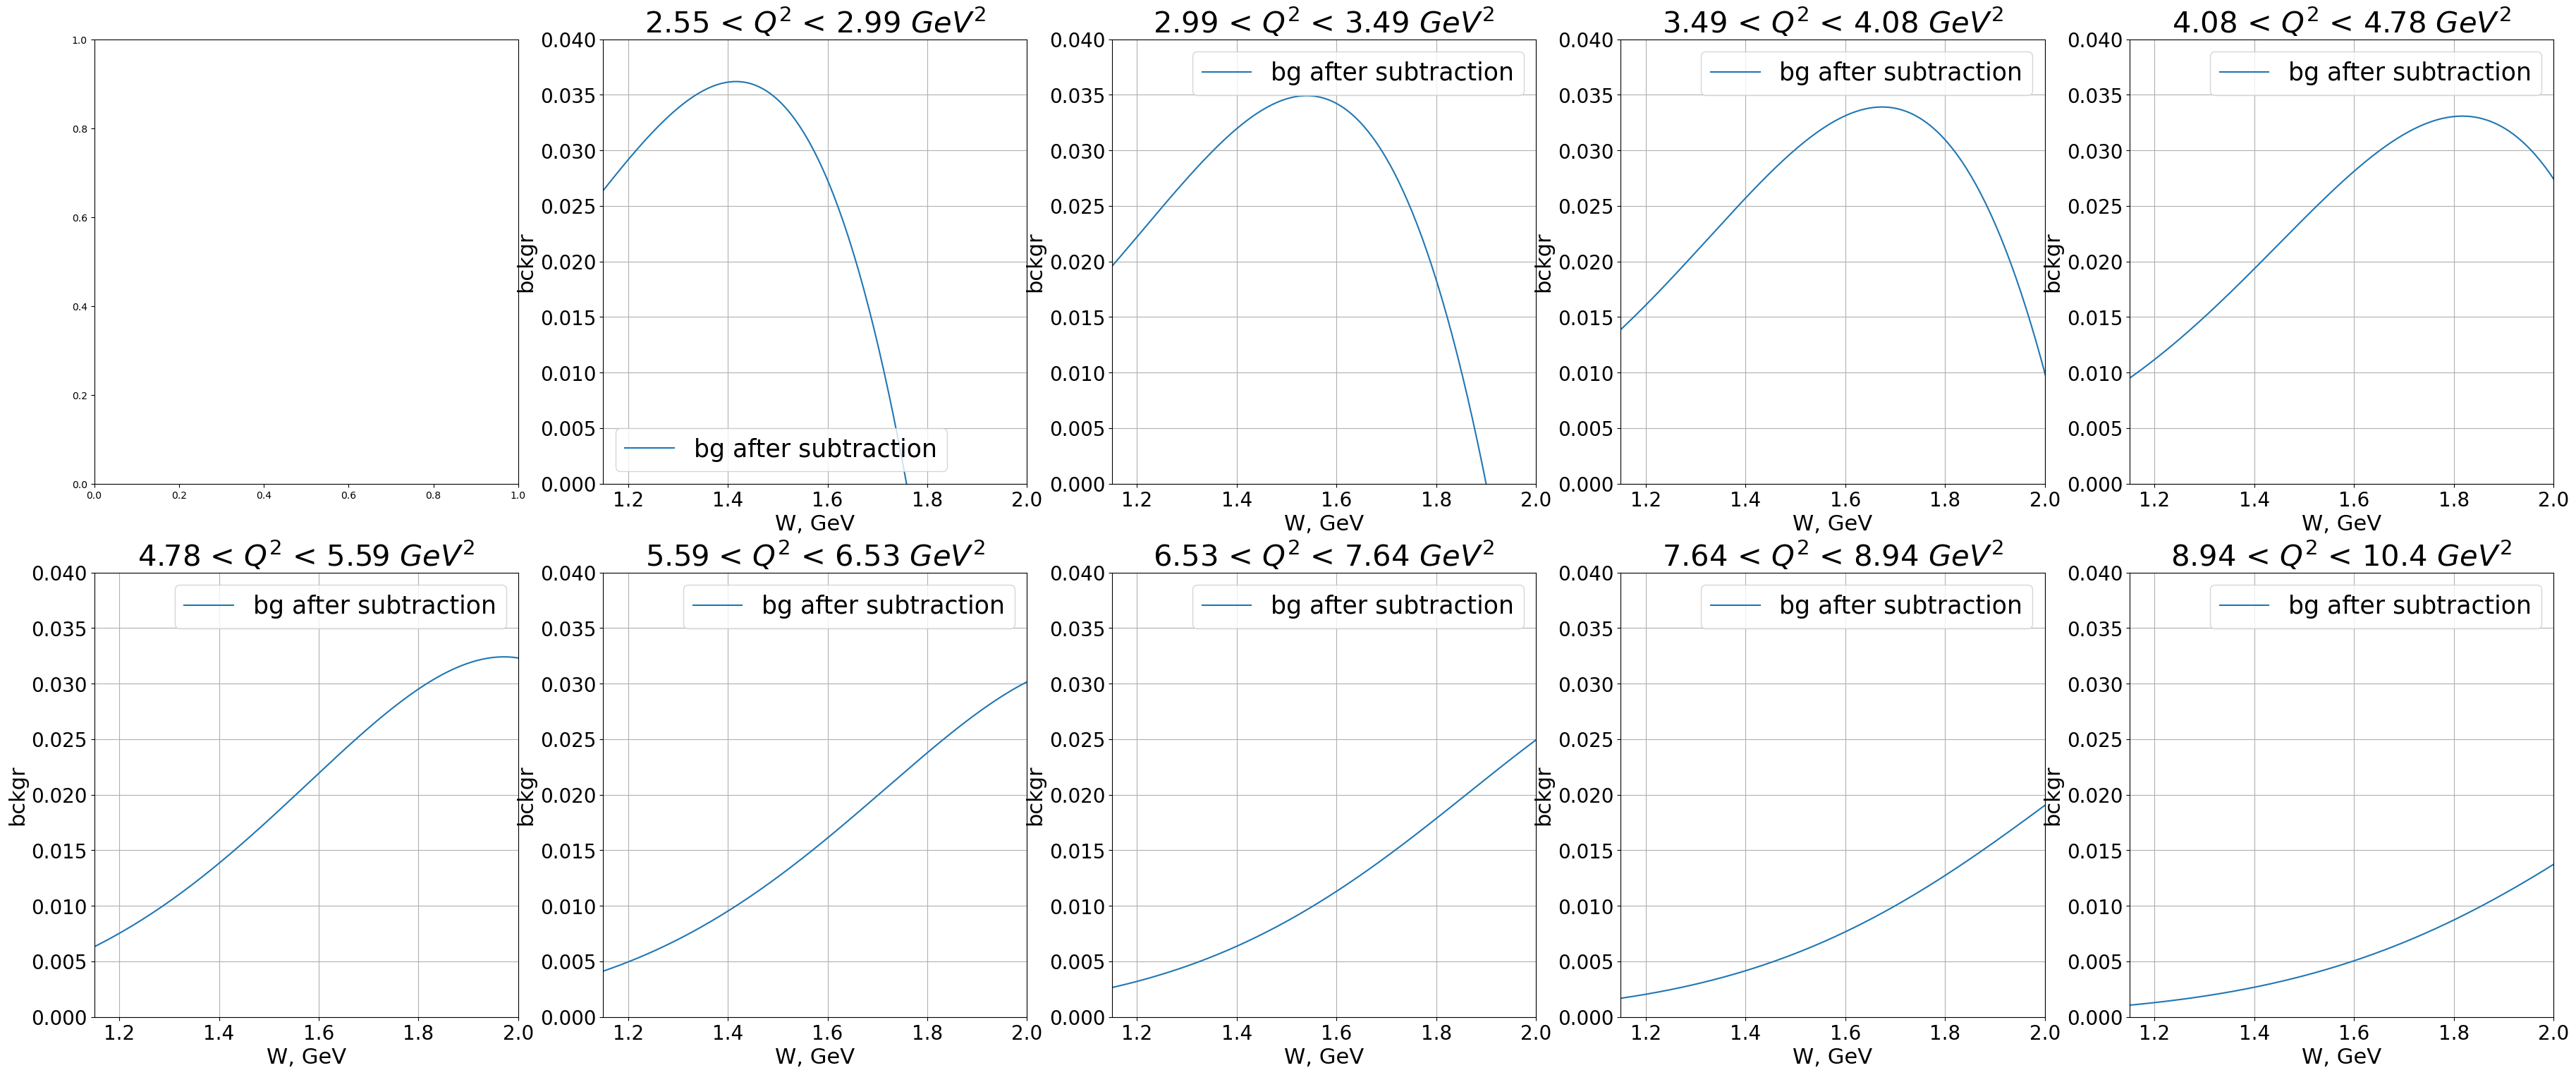

<Figure size 640x480 with 0 Axes>

In [61]:
# compare two bckgrd funs:

fig, axes = plt.subplots(nrows=2,ncols=5,figsize=(45,18))
for iQ2 in range(1,10,1):
    
    x = []
    y = []
    y_0 = []
    y_1 = []
    y_2 = []
    q2 = xx_elas[0 + (iQ2-1) * 14]

    # PRC:
    backParams_PRC = [0.2367, 2.178, 0.898, -6.726, 3.718]

    # Iterated by Valerii after PRC:
    backParams_after_PRC = [0.2367, 2.185651400350511, 0.6782367867507779, -6.735990002785817, 4.163236272156371]

    bg_params_exp_minus_pdf = [0.2367, -0.0375943454827298, 4.968682500440749, -4.2722561482930175, -12.8657473408563]
    
    for xW in np.linspace(1.1, 2.6, num=300):
        x.append(xW)
        #y.append(PlotBack(q2, xW, *backParams_PRC))
        #y_0.append(PlotBack(q2, xW, *backParams_after_PRC))
        y_1.append(PlotBack(q2, xW, *bg_params_exp_minus_pdf))
        
    title = str(Q2bins[iQ2])[0:4] + ' < $Q^2$ < ' + str(Q2bins[iQ2 +1])[0:5] + " $GeV^2$"
    axes[int(iQ2/5),iQ2%5].set_title(title, fontsize=30) 
    axes[int(iQ2/5),iQ2%5].set_ylabel("bckgr", fontsize=22)
    
    #axes[int(iQ2/5),iQ2%5].plot(x, y, label = "PRC") 
    #axes[int(iQ2/5),iQ2%5].plot(x, y_0, label = "After PRC") 
    axes[int(iQ2/5),iQ2%5].plot(x, y_1, label = "bg after subtraction") 
    
    
    axes[int(iQ2/5),iQ2%5].set_xlabel('W, GeV', fontsize=22)
    axes[int(iQ2/5), iQ2%5].set_xlim([1.15, 2])
    axes[int(iQ2/5), iQ2%5].set_ylim([0, 0.04])
    axes[int(iQ2/5),iQ2%5].grid(True)
    axes[int(iQ2/5),iQ2%5].tick_params(axis='both', which='major', labelsize=20)
    axes[int(iQ2/5),iQ2%5].legend(fontsize=25)
# 0.135 -  0.694   
plt.figure()
fig.savefig('Bg_after_subtraction.png')

In [55]:
import ROOT

def mincalc(pp):
    chi2 = 0
    with open('exp_minus_pdf.txt') as ff:
        ff.readline()
        for line in ff:
            xx,yy, eps, yexp, dyexp_1, dyexp_2, dyexp_3 = [float(vv) for vv in line.strip().split(',')]
            dyexp = math.sqrt(dyexp_1**2 + dyexp_2**2 + dyexp_3**2)
            
            #backParams_after_PRC = [0.2367, 2.185651400350511, 0.6782367867507779, -6.735990002785817, 4.163236272156371]
            bg_params_exp_minus_pdf = [0.2367, -0.0375943454827298, 4.968682500440749, -4.2722561482930175, -12.8657473408563]
            ytheory = getXSEC_fitting(xx,yy, *bg_params_exp_minus_pdf, pp[0], pp[1], pp[2], pp[3], pp[4], pp[5], pp[6], pp[7], pp[8], pp[9], pp[10])
            
            chi2 += (yexp-ytheory)**2/dyexp**2
            #print(yexp, ytheory)
        return chi2
        
pp= [1.5,1.711,1.94343, 1.14391, 6.21974e-01,  5.14898e-01,
     5.13290e-01 , 1.14735e-01, 1.22690e-01, 1.17700e-01, 2.02702e-01]

print(mincalc(pp))


minimum = ROOT.Math.Factory.CreateMinimizer("Minuit", "Migrad")

minimum.SetMaxFunctionCalls(10000000)
minimum.SetMaxIterations(100000)
minimum.SetTolerance(0.0001)
minimum.SetPrintLevel(1)

fh = ROOT.Math.Functor(mincalc, 11)
minimum.SetFunction(fh)


p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11 = [1.5,1.711,1.94343, 1.14391, 6.21974e-01,  5.14898e-01,
                                                5.13290e-01 , 1.14735e-01, 1.22690e-01, 1.17700e-01, 2.02702e-01]

minimum.SetVariable(0, "p1", p1, 0.001)
minimum.SetVariable(1, "p2", p2, 0.001)
minimum.SetVariable(2, "p3", p3, 0.001)
minimum.SetVariable(3, "p4", p4, 0.0001)
minimum.SetVariable(4, "p5", p5, 0.0001)
minimum.SetVariable(5, "p6", p6, 0.0001)
minimum.SetVariable(6, "p7", p7, 0.0001)
minimum.SetVariable(7, "p8", p8, 0.0001)
minimum.SetVariable(8, "p9", p9, 0.0001)
minimum.SetVariable(9, "p10", p10, 0.0001)
minimum.SetVariable(10, "p11", p11, 0.0001)
#minimum.SetVariable(11, "p12", p12, 0.01)

minimum.Minimize()


754.8038596674921


False

 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 p1           1.50000e+00  1.00000e-03     no limits
     2 p2           1.71100e+00  1.00000e-03     no limits
     3 p3           1.94343e+00  1.00000e-03     no limits
     4 p4           1.14391e+00  1.00000e-04     no limits
     5 p5           6.21974e-01  1.00000e-04     no limits
     6 p6           5.14898e-01  1.00000e-04     no limits
     7 p7           5.13290e-01  1.00000e-04     no limits
     8 p8           1.14735e-01  1.00000e-04     no limits
     9 p9           1.22690e-01  1.00000e-04     no limits
    10 p10          1.17700e-01  1.00000e-04     no limits
    11 p11          2.02702e-01  1.00000e-04     no limits
 **********
 **    3 **SET ERR           1
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 

In [56]:
for i in range(11):
 print(minimum.X()[i], end = ', ')


1.5, 1.711, 1.94343, 1.14391, 0.621974, 0.514898, 0.51329, 0.114735, 0.12269, 0.1177, 0.202702, 

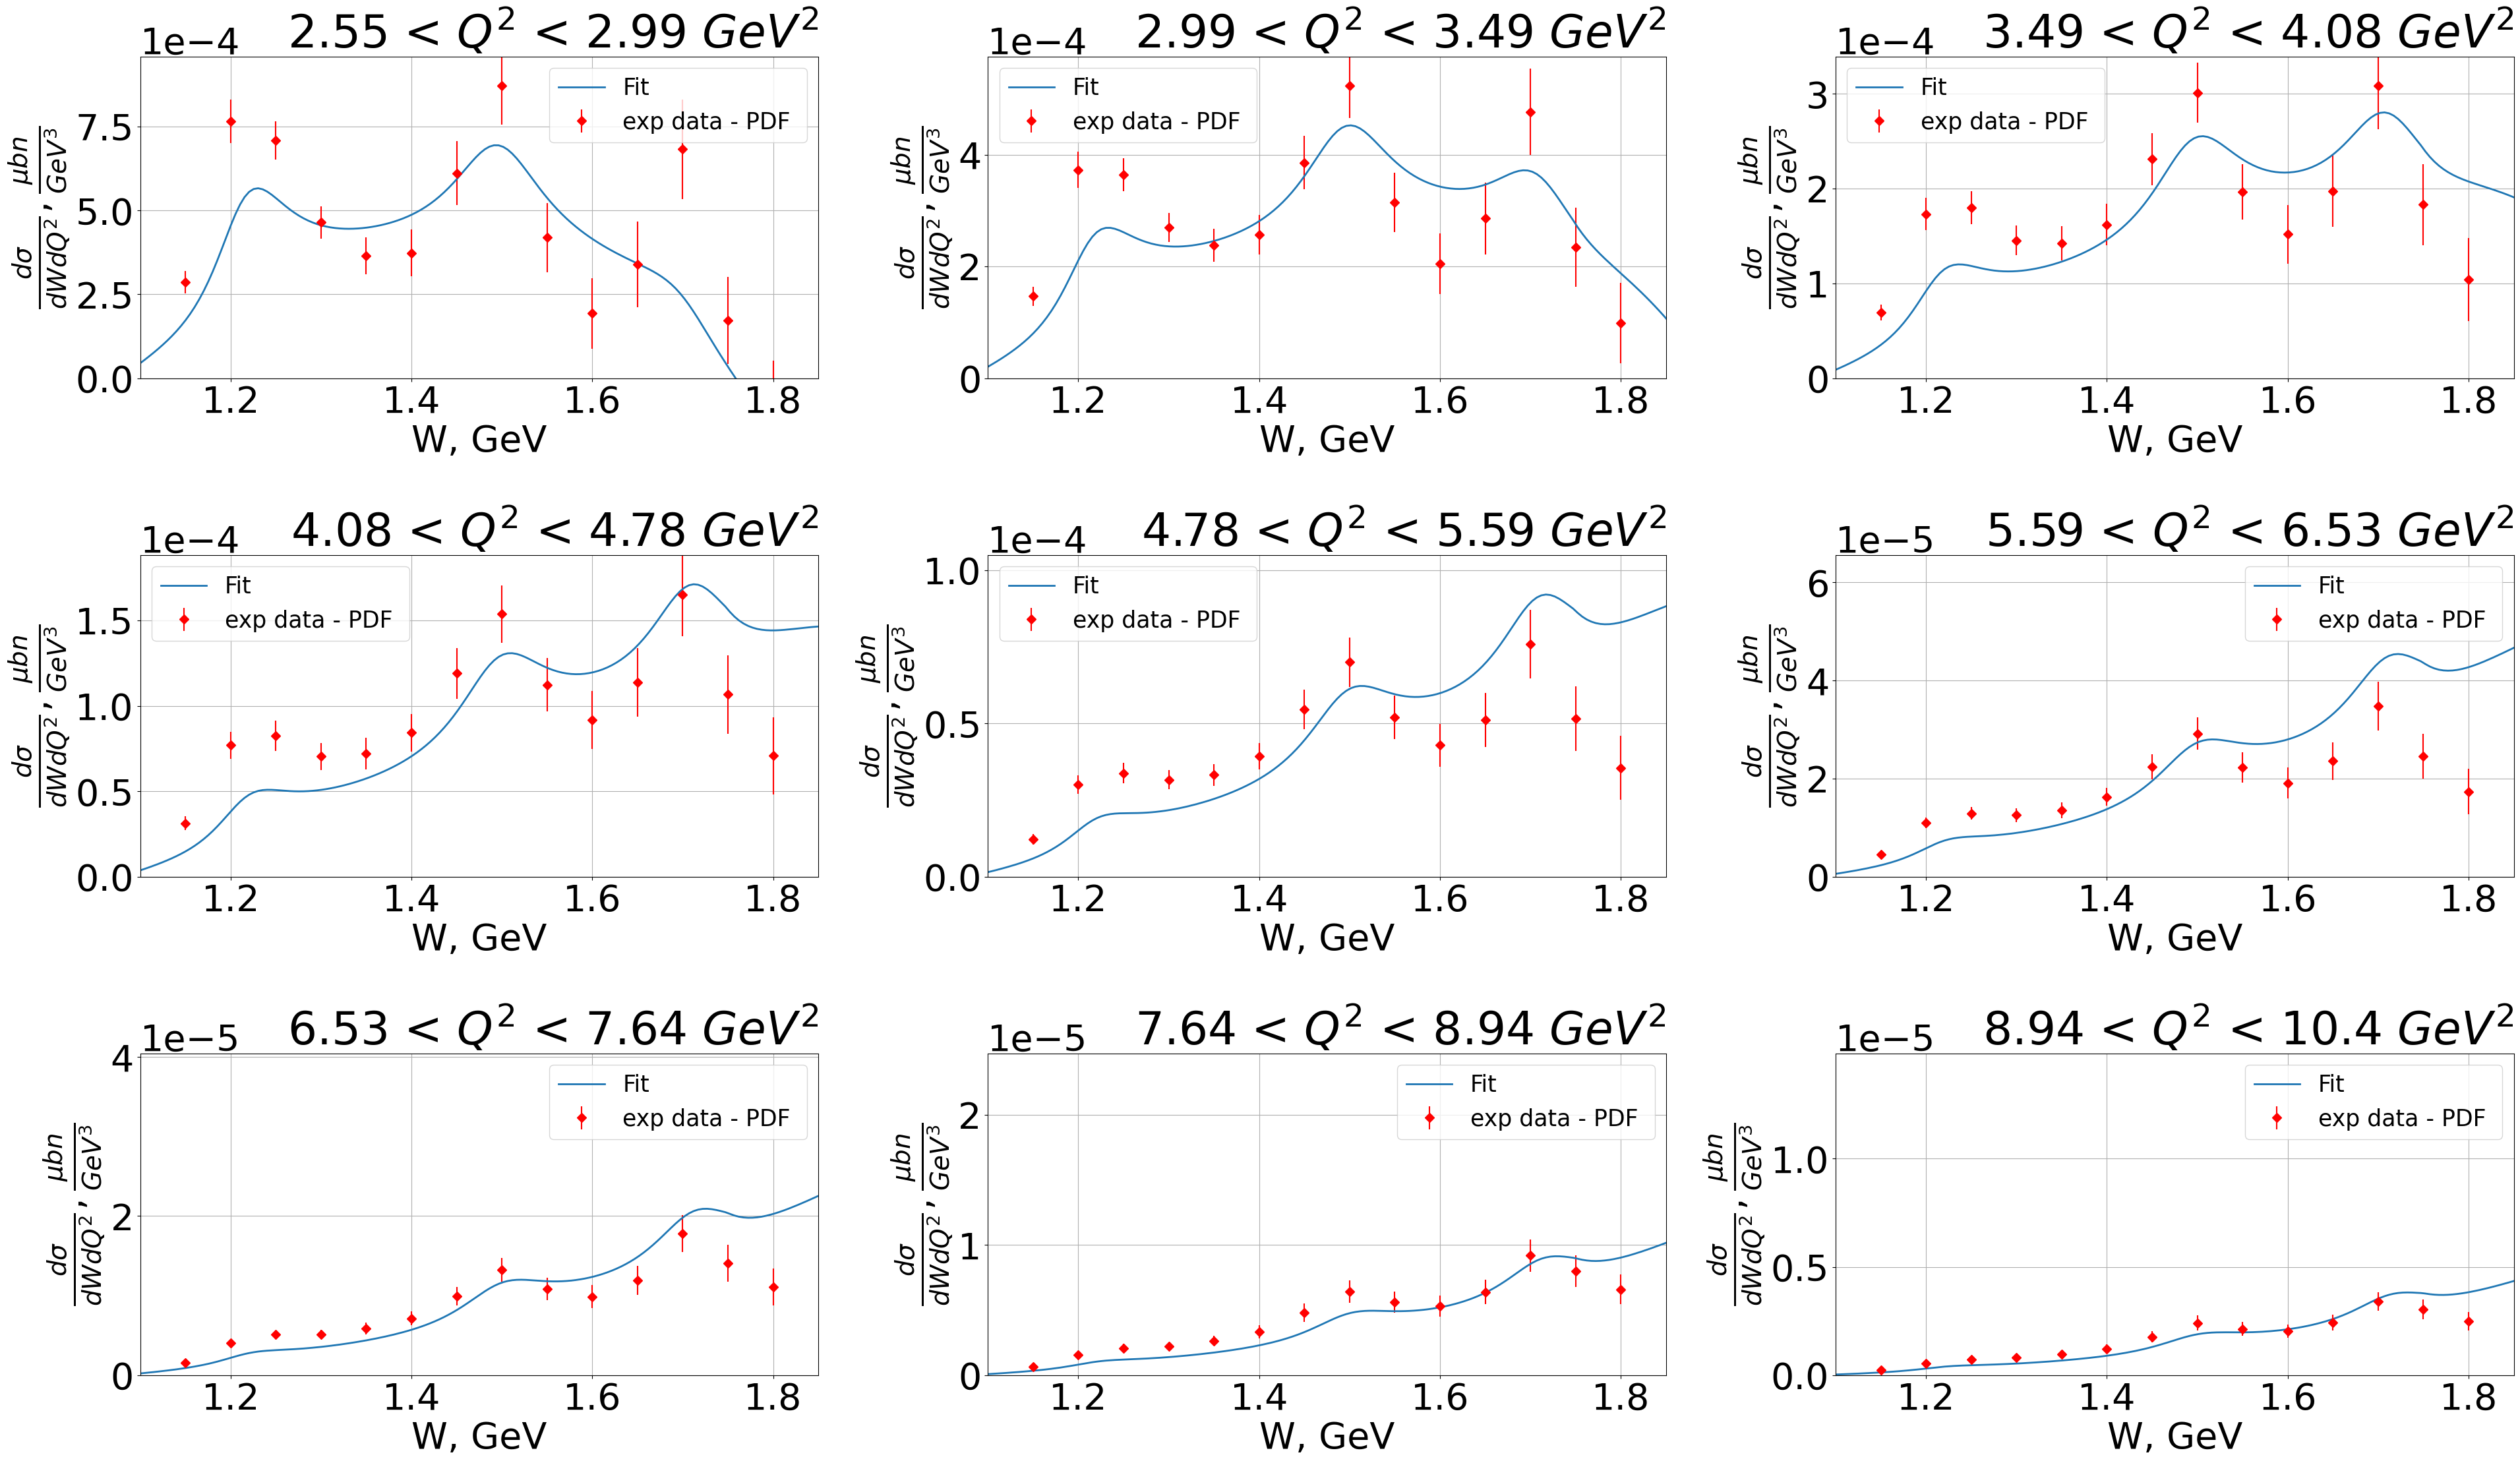

<Figure size 640x480 with 0 Axes>

In [58]:
# compare tow xsecs

import matplotlib.pyplot as plt
import numpy as np

Q2bins = [2.18,2.55,2.99,3.49,4.08,4.78,5.59,6.53,7.64,8.94,10.4]

xx_elas = []
yy_elas = []
yexp_elas = []
dyexp_elas = []

with open('exp_minus_pdf.txt') as ff:
    ff.readline()
    for line in ff:
        xx,yy, eps, yexp, dyexp_1, dyexp_2, dyexp_3 = [float(vv) for vv in line.strip().split(',')]
        dyexp = math.sqrt(dyexp_1**2 + dyexp_2**2 + dyexp_3**2)
            
        xx_elas.append(xx)
        yy_elas.append(yy)
        yexp_elas.append(yexp)
        dyexp_elas.append(dyexp)

fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(45,25))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.55)




# PRC:
#backParams_PRC = [0.2367, 2.178, 0.898, -6.726, 3.718]
#bodekParams_PRC = [1.5,1.711,1.94343, 1.14391, 6.21974e-01,  5.14898e-01, 5.13290e-01 , 1.14735e-01, 1.22690e-01, 1.17700e-01, 2.02702e-01]

# Iterated by Valerii after PRC:
#backParams_after_PRC = [0.2367, 2.185651400350511, 0.6782367867507779, -6.735990002785817, 4.163236272156371]
#bodekParams_after_PRC = [1.5, 1.711, 1.9455061694828741, 1.1508931812039305, 0.622807570128967, 0.5140353260311096, 0.5197534788784222, 0.10792042803309153, 0.12666581366215277, 0.1179007082920964, 0.20173174661509075] 

#exp minus pdf
bg_params_exp_minus_pdf = [0.2367, -0.0375943454827298, 4.968682500440749, -4.2722561482930175, -12.8657473408563]
bodek_params_exp_minus_pdf = [1.5, 1.711, 1.94343, 1.14391, 0.621974, 0.514898, 0.51329, 0.114735, 0.12269, 0.1177, 0.202702]

for iQ2 in range(1,10,1):
    
    x = []
    y = []
    y_0 = []
    y_prc = []
    y_after_prc = []
    q2 = xx_elas[0 + (iQ2-1) * 14]
    
    
    plotX = int((iQ2-1)/3)
    plotY = int((iQ2-1)%3)


    for xW in np.linspace(1.1, 2.6, num=300):
        x.append(xW)
        #PRC
        y_prc.append(getCS(q2, xW, isBackPass = True, isBodekPass = True, backParams = bg_params_exp_minus_pdf, bodekParams = bodek_params_exp_minus_pdf))
        #y_after_prc.append(getCS(q2, xW, isBackPass = True, isBodekPass = True, backParams = backParams_after_PRC, bodekParams = bodekParams_after_PRC))


    sp = 0 + (iQ2-1) * 14
    endp = 0 + (iQ2) * 14
    
    #if (iQ2 == 9):
      #  sp-=5

    axes[plotX, plotY].errorbar(yy_elas[sp:endp], yexp_elas[sp:endp], yerr=dyexp_elas[sp:endp], linestyle="None", marker='D', markersize=7, color = 'red', label='exp data - PDF ')  
    
    axes[plotX, plotY].plot(x, y_prc, label='Fit', linewidth=2)    
    #axes[plotX, plotY].plot(x, y_after_prc, label='After PRC', color = 'purple', linewidth=2)    
    
    
    title = str(Q2bins[iQ2])[0:4] + ' < $Q^2$ < ' + str(Q2bins[iQ2 +1])[0:5] + " $GeV^2$"
    axes[plotX,plotY].set_title(title, fontsize=50, loc='right') 
    axes[plotX,plotY].set_ylabel(r"$\frac{d\sigma}{dWdQ^{2}}, $"
                                 r"$\frac{\mu bn}{GeV^{3}}$", fontsize=40)
    axes[plotX, plotY].set_xlabel('W, GeV', fontsize=40)
    axes[plotX, plotY].grid(True)
    axes[plotX, plotY].tick_params(axis='both', which='major', labelsize=40)
    axes[plotX, plotY].ticklabel_format(style='sci', axis='y', scilimits=(-3,-6))
    axes[plotX, plotY].yaxis.get_offset_text().set_fontsize(40)
    axes[plotX, plotY].legend(fontsize=25)
    axes[plotX, plotY].set_xlim([1.1, 1.85])
    max_data = max(yexp_elas[sp:endp])
    max_model = max(y_prc)
    ymax = max(max_data, max_model)
    axes[plotX, plotY].set_ylim([0, ymax * 1.1])
  
    
    
plt.figure()
fig.savefig('Models_afterPRC.png', bbox_inches='tight', dpi = 50)